In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!cp '/content/drive/MyDrive/RoseYoutu/maskrose.zip' './'

In [ ]:
!cp '/content/drive/MyDrive/RoseYoutu/imposter.txt' './'

In [ ]:
!cp '/content/drive/MyDrive/RoseYoutu/client.txt' './'

In [ ]:
!wget "http://dlib.net/files/shape_predictor_68_face_landmarks.dat.bz2"

--2021-05-29 03:53:39--  http://dlib.net/files/shape_predictor_68_face_landmarks.dat.bz2
Resolving dlib.net (dlib.net)... 107.180.26.78
Connecting to dlib.net (dlib.net)|107.180.26.78|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 64040097 (61M)
Saving to: ‘shape_predictor_68_face_landmarks.dat.bz2’

shape_predictor_68_ 100%[===================>]  61.07M  15.6MB/s    in 5.3s    

2021-05-29 03:53:45 (11.5 MB/s) - ‘shape_predictor_68_face_landmarks.dat.bz2’ saved [64040097/64040097]



In [ ]:
!bzip2 -d "shape_predictor_68_face_landmarks.dat.bz2"

In [ ]:
!unzip maskrose.zip

Streaming output truncated to the last 5000 lines.
  inflating: maskrose/imposter/Vm_NT_5s_g_E_22_161/test68.jpg  
  inflating: maskrose/imposter/Vm_NT_5s_g_E_22_161/test69.jpg  
  inflating: maskrose/imposter/Vm_NT_5s_g_E_22_161/test7.jpg  
  inflating: maskrose/imposter/Vm_NT_5s_g_E_22_161/test70.jpg  
  inflating: maskrose/imposter/Vm_NT_5s_g_E_22_161/test71.jpg  
  inflating: maskrose/imposter/Vm_NT_5s_g_E_22_161/test72.jpg  
  inflating: maskrose/imposter/Vm_NT_5s_g_E_22_161/test73.jpg  
  inflating: maskrose/imposter/Vm_NT_5s_g_E_22_161/test74.jpg  
  inflating: maskrose/imposter/Vm_NT_5s_g_E_22_161/test75.jpg  
  inflating: maskrose/imposter/Vm_NT_5s_g_E_22_161/test76.jpg  
  inflating: maskrose/imposter/Vm_NT_5s_g_E_22_161/test77.jpg  
  inflating: maskrose/imposter/Vm_NT_5s_g_E_22_161/test78.jpg  
  inflating: maskrose/imposter/Vm_NT_5s_g_E_22_161/test79.jpg  
  inflating: maskrose/imposter/Vm_NT_5s_g_E_22_161/test8.jpg  
  inflating: maskrose/imposter/Vm_NT_5s_g_E_22_161/test

In [ ]:
import cv2
import dlib
import numpy as np
import os
from imutils import paths
import pickle
import random
from scipy.stats import norm
INPUT_SIZE = 112


In [ ]:
detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor('shape_predictor_68_face_landmarks.dat')
client_dataset = {}
for name in os.listdir('/content/maskrose/client'):
    client_dataset[name] = []

In [ ]:
# imagePaths = list(paths.list_images('/content/data_rose/client'))
imagePaths = list(map(lambda x: x.rstrip(),open('client.txt').readlines()))
num_of_images = len(imagePaths)
for(i, data) in enumerate(imagePaths):
    print(data)
    print(f'Processing image {i}/{num_of_images}')
    label = data.split('/')[-2]
    img = dlib.load_rgb_image(data)
    dets = detector(img)
    for d in dets:
        shape = predictor(img, d)
        temp = dlib.get_face_chip(img, shape, size=INPUT_SIZE)
        # temp = temp.astype('float32')
        # standardize pixel values across channels (global)
        # mean, std = temp.mean(), temp.std()
        # temp = (temp - mean) / std
        # client_dataset[label].append(temp.reshape(1, INPUT_SIZE, INPUT_SIZE, 3))
        client_dataset[label].append(temp)

Streaming output truncated to the last 5000 lines.
/content/maskrose/client/G_NT_5s_wg_E_3_9/test48.jpg
Processing image 14476/16976
/content/maskrose/client/G_NT_5s_wg_E_3_9/test49.jpg
Processing image 14477/16976
/content/maskrose/client/G_NT_5s_wg_E_3_9/test50.jpg
Processing image 14478/16976
/content/maskrose/client/G_NT_5s_wg_E_3_9/test51.jpg
Processing image 14479/16976
/content/maskrose/client/G_NT_5s_wg_E_3_9/test52.jpg
Processing image 14480/16976
/content/maskrose/client/G_NT_5s_wg_E_3_9/test53.jpg
Processing image 14481/16976
/content/maskrose/client/G_NT_5s_wg_E_3_9/test54.jpg
Processing image 14482/16976
/content/maskrose/client/G_NT_5s_wg_E_3_9/test55.jpg
Processing image 14483/16976
/content/maskrose/client/G_NT_5s_wg_E_3_9/test56.jpg
Processing image 14484/16976
/content/maskrose/client/G_NT_5s_wg_E_3_9/test57.jpg
Processing image 14485/16976
/content/maskrose/client/G_NT_5s_wg_E_3_9/test58.jpg
Processing image 14486/16976
/content/maskrose/client/G_NT_5s_wg_E_3_9/test5

#Rank Pooling

In [ ]:
import random
import collections
from PIL import Image, ImageFilter, ImageOps
import numpy as np
import cv2
import tqdm
import scipy.sparse
from sklearn import svm

In [ ]:
class RankPooling(object):
    def __init__(self, C, nonlinear='ssr'):
        self.C = C
        self.nonlinear = nonlinear

    def _smoothSeq(self, seq):
        res = np.cumsum(seq, axis=1)
        seq_len = np.size(res, 1)
        res = res / np.expand_dims(np.linspace(1, seq_len, seq_len), 0)
        return res

    def _rootExpandKernelMap(self, data):

        element_sign = np.sign(data)
        nonlinear_value = np.sqrt(np.fabs(data))
        return np.vstack((nonlinear_value * (element_sign > 0), nonlinear_value * (element_sign < 0)))

    def _getNonLinearity(self, data, nonLin='ref'):

        # we don't provide the Chi2 kernel in our code
        if nonLin == 'none':
            return data
        if nonLin == 'ref':
            return self._rootExpandKernelMap(data)
        elif nonLin == 'tanh':
            return np.tanh(data)
        elif nonLin == 'ssr':
            return np.sign(data) * np.sqrt(np.fabs(data))
        else:
            raise ("We don't provide {} non-linear transformation".format(nonLin))

    def _normalize(self, seq, norm='l2'):

        if norm == 'l2':
            seq_norm = np.linalg.norm(seq, ord=2, axis=0)
            seq_norm[seq_norm == 0] = 1
            seq_norm = seq / np.expand_dims(seq_norm, 0)
            return seq_norm
        elif norm == 'l1':
            seq_norm = np.linalg.norm(seq, ord=1, axis=0)
            seq_norm[seq_norm == 0] = 1
            seq_norm = seq / np.expand_dims(seq_norm, 0)
            return seq_norm
        else:
            raise ("We only provide l1 and l2 normalization methods")

    def _rank_pooling(self, time_seq, NLStyle='ssr'):
        '''
        This function only calculate the positive direction of rank pooling.
        :param time_seq: D x T
        :param C: hyperparameter
        :param NLStyle: Nonlinear transformation.Including: 'ref', 'tanh', 'ssr'.
        :return: Result of rank pooling
        '''

        seq_smooth = self._smoothSeq(time_seq)
        seq_nonlinear = self._getNonLinearity(seq_smooth, NLStyle)
        seq_norm = self._normalize(seq_nonlinear)
        seq_len = np.size(seq_norm, 1)
        Labels = np.array(range(1, seq_len + 1))
        seq_svr = scipy.sparse.csr_matrix(np.transpose(seq_norm))
        svr_model = svm.LinearSVR(epsilon=0.1,
                                  tol=0.001,
                                  C=self.C,
                                  loss='squared_epsilon_insensitive',
                                  fit_intercept=False,
                                  dual=False,
                                  random_state=42)
        svr_model.fit(seq_svr, Labels)
        return svr_model.coef_

    def run(self, images):
        np_images = np.array([np.array(x) for x in images])
        input_arr = np_images.reshape((np_images.shape[0], -1)).T
        result_img = self._rank_pooling(input_arr).reshape(np_images.shape[1:])
        result_img = (result_img - result_img.min()) / (result_img.max() - result_img.min())
        # return result_img
        return (result_img * 255).astype(np.uint8)
        # return Image.fromarray((result_img * 255).astype(np.uint8))

    def __repr__(self):
        format_string = self.__class__.__name__
        format_string += f'(C={self.C}, '
        format_string += f'nonlinear={self.nonlinear})'
        return format_string

In [ ]:
C1 = RankPooling(1)

In [ ]:
res = C1.run(client_dataset['G_NT_5s_g_E_11_1'][:20])

In [ ]:
import matplotlib.pyplot as plt

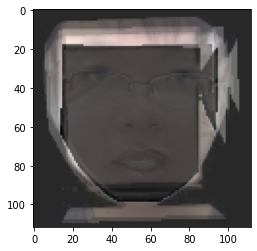

In [ ]:
plt.imshow(res)

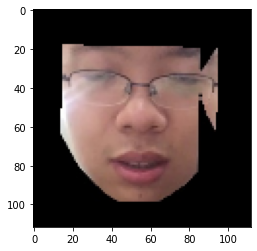

In [ ]:
plt.imshow(client_dataset['G_NT_5s_g_E_11_1'][0])

In [ ]:
C1000 = RankPooling(1000)

In [ ]:
res = C1000.run(client_dataset['G_NT_5s_g_E_11_1'][:20])

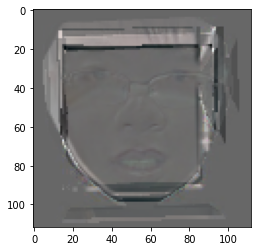

In [ ]:
plt.imshow(res)

# processing


In [ ]:
C1_ = []
C1000_ = []
X_10 = []
X_20 = []
for (key, values) in tqdm.tqdm(client_dataset.items()):
  for i in range(len(values)):
    if len(values) < 20:
      print('Not valid')
      break
    if i + 19 > len(values) - 1 :
      break
    else:
      old = values[i][...,::-1]
      new_10 = values[i+9][...,::-1]
      new_20 = values[i+19][...,::-1]
      old_gray = cv2.cvtColor(old, cv2.COLOR_BGR2GRAY)
      new_10_gray = cv2.cvtColor(new_10, cv2.COLOR_BGR2GRAY)
      new_20_gray = cv2.cvtColor(new_20, cv2.COLOR_BGR2GRAY)
      flow = cv2.calcOpticalFlowFarneback(old_gray, new_10_gray, None, 0.5, 3, 29, 3, 5, 1.2, 0)
      X_10.append(flow)
      flow = cv2.calcOpticalFlowFarneback(old_gray, new_20_gray, None, 0.5, 3, 29, 3, 5, 1.2, 0)
      X_20.append(flow)
      rankpooling_1 = C1.run(values[i:i+20])
      C1_.append(rankpooling_1)
      rankpooling_1000 = C1000.run(values[i:i+20])
      C1000_.append(rankpooling_1000)


  4%|▍         | 8/180 [01:46<38:30, 13.43s/it]

Not valid


100%|██████████| 180/180 [43:35<00:00, 14.53s/it]


In [ ]:
del client_dataset

In [ ]:
C1_ = np.array(C1_)
C1000_ = np.array(C1000_)
X_10 = np.array(X_10)
X_20 = np.array(X_20)
C1_.shape, C1000_.shape, X_10.shape, X_20.shape

((13083, 112, 112, 3),
 (13083, 112, 112, 3),
 (13083, 112, 112, 2),
 (13083, 112, 112, 2))

In [ ]:
detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor('shape_predictor_68_face_landmarks.dat')
imposter_dataset = {}
for name in os.listdir('/content/maskrose/imposter'):
    imposter_dataset[name] = []

In [ ]:
# imagePaths = list(paths.list_images('/content/data_rose/imposter'))
imagePaths = list(map(lambda x: x.rstrip(),open('imposter.txt').readlines()))
num_of_images = len(imagePaths)
for(i, data) in enumerate(imagePaths):
    print(data)
    print(f'Processing image {i}/{num_of_images}')
    label = data.split('/')[-2]
    img = dlib.load_rgb_image(data)
    dets = detector(img)
    for d in dets:
        shape = predictor(img, d)
        temp = dlib.get_face_chip(img, shape, size=INPUT_SIZE)
        # temp = temp.astype('float32')
        # standardize pixel values across channels (global)
        # mean, std = temp.mean(), temp.std()
        # temp = (temp - mean) / std
        # imposter_dataset[label].append(temp.reshape(1, INPUT_SIZE, INPUT_SIZE, 3))
        imposter_dataset[label].append(temp)

Streaming output truncated to the last 5000 lines.
/content/maskrose/imposter/Ps_NT_5s_wg_E_15_95/test47.jpg
Processing image 12593/15093
/content/maskrose/imposter/Ps_NT_5s_wg_E_15_95/test48.jpg
Processing image 12594/15093
/content/maskrose/imposter/Ps_NT_5s_wg_E_15_95/test49.jpg
Processing image 12595/15093
/content/maskrose/imposter/Ps_NT_5s_wg_E_15_95/test50.jpg
Processing image 12596/15093
/content/maskrose/imposter/Ps_NT_5s_wg_E_15_95/test51.jpg
Processing image 12597/15093
/content/maskrose/imposter/Ps_NT_5s_wg_E_15_95/test52.jpg
Processing image 12598/15093
/content/maskrose/imposter/Ps_NT_5s_wg_E_15_95/test53.jpg
Processing image 12599/15093
/content/maskrose/imposter/Ps_NT_5s_wg_E_15_95/test54.jpg
Processing image 12600/15093
/content/maskrose/imposter/Ps_NT_5s_wg_E_15_95/test55.jpg
Processing image 12601/15093
/content/maskrose/imposter/Ps_NT_5s_wg_E_15_95/test56.jpg
Processing image 12602/15093
/content/maskrose/imposter/Ps_NT_5s_wg_E_15_95/test57.jpg
Processing image 1260

In [ ]:
C1_imposter = []
C1000_imposter = []
X_10_imposter = []
X_20_imposter = []
for (key, values) in tqdm.tqdm(imposter_dataset.items()):
  for i in range(len(values)):
    if len(values) < 20:
      print('Not valid')
      break
    if i + 19 > len(values) - 1 :
      break
    else:
      old = values[i][...,::-1]
      new_10 = values[i+9][...,::-1]
      new_20 = values[i+19][...,::-1]
      old_gray = cv2.cvtColor(old, cv2.COLOR_BGR2GRAY)
      new_10_gray = cv2.cvtColor(new_10, cv2.COLOR_BGR2GRAY)
      new_20_gray = cv2.cvtColor(new_20, cv2.COLOR_BGR2GRAY)
      flow = cv2.calcOpticalFlowFarneback(old_gray, new_10_gray, None, 0.5, 3, 29, 3, 5, 1.2, 0)
      X_10_imposter.append(flow)
      flow = cv2.calcOpticalFlowFarneback(old_gray, new_20_gray, None, 0.5, 3, 29, 3, 5, 1.2, 0)
      X_20_imposter.append(flow)
      rankpooling_1 = C1.run(values[i:i+20])
      C1_imposter.append(rankpooling_1)
      rankpooling_1000 = C1000.run(values[i:i+20])
      C1000_imposter.append(rankpooling_1000)


  2%|▏         | 6/342 [01:00<58:01, 10.36s/it]

Not valid


  9%|▉         | 31/342 [03:49<42:35,  8.22s/it]

Not valid


 28%|██▊       | 95/342 [09:15<39:29,  9.59s/it]

Not valid


 31%|███       | 106/342 [10:13<33:04,  8.41s/it]

Not valid


 46%|████▌     | 156/342 [14:15<19:07,  6.17s/it]

Not valid


 60%|█████▉    | 204/342 [19:53<28:02, 12.20s/it]

Not valid


 75%|███████▍  | 255/342 [24:15<11:27,  7.90s/it]

Not valid


 89%|████████▉ | 304/342 [29:12<03:31,  5.56s/it]

Not valid


 91%|█████████ | 310/342 [29:45<03:43,  6.99s/it]

Not valid


100%|██████████| 342/342 [32:19<00:00,  5.67s/it]

Not valid


In [ ]:
del imposter_dataset

In [ ]:
C1_imposter = np.array(C1_imposter)
C1000_imposter = np.array(C1000_imposter)
X_10_imposter = np.array(X_10_imposter)
X_20_imposter = np.array(X_20_imposter)
C1_imposter.shape, C1000_imposter.shape, X_10_imposter.shape, X_20_imposter.shape

((9368, 112, 112, 3),
 (9368, 112, 112, 3),
 (9368, 112, 112, 2),
 (9368, 112, 112, 2))

In [ ]:
y = np.array([0]*C1_.shape[0] + [1]*C1_imposter.shape[0])

In [ ]:
C1_total = np.vstack((C1_, C1_imposter))
del C1_
del C1_imposter

C1000_total = np.vstack((C1000_, C1000_imposter))
del C1000_
del C1000_imposter

X_10_total = np.vstack((X_10, X_10_imposter))
del X_10
del X_10_imposter

X_20_total = np.vstack((X_20, X_20_imposter))
del X_20
del X_20_imposter

In [ ]:
with open('C1_total.pickle', 'wb') as handle:
  pickle.dump(C1_total, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
with open('C1000_total.pickle', 'wb') as handle:
  pickle.dump(C1000_total, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
with open('X_10_total.pickle', 'wb') as handle:
  pickle.dump(X_10_total, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
with open('X_20_total.pickle', 'wb') as handle:
  pickle.dump(X_20_total, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
X_C = np.array(list(zip(C1_total, C1000_total)))
X_C.shape

(22451, 2, 112, 112, 3)

In [ ]:
del C1_total
del C1000_total

In [ ]:
X = np.array(list(zip(X_10_total, X_20_total)))
X.shape

(22451, 2, 112, 112, 2)

In [ ]:
y.shape

(22451,)

In [ ]:
del X_10_total
del X_20_total

In [ ]:
with open('X_4_10.pickle', 'wb') as handle:
  pickle.dump(X, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
with open('y_4_10.pickle', 'wb') as handle:
  pickle.dump(y, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
with open('X_C_4_10.pickle', 'wb') as handle:
  pickle.dump(X_C, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
!cp 'X_4_10.pickle' '/content/drive/MyDrive/RoseYoutu/'

In [ ]:
!cp 'X_C_4_10.pickle' '/content/drive/MyDrive/RoseYoutu/'

In [ ]:
!cp 'y_4_10.pickle' '/content/drive/MyDrive/RoseYoutu/'

In [ ]:
with open('X_4_10.pickle', 'rb') as handle:
  X = pickle.load(handle)

In [ ]:
with open('y_4_10.pickle', 'rb') as handle:
  y = pickle.load(handle)

In [ ]:
with open('X_C_4_10.pickle', 'rb') as handle:
  X_C = pickle.load(handle)

In [ ]:
from sklearn.model_selection import train_test_split
X_train,  X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=42)

In [ ]:
from sklearn.model_selection import train_test_split
X_train_C,  X_test_C, y_train_C, y_test_C = train_test_split(X_C, y, test_size = 0.2, random_state=42)

In [ ]:
False in (y_train == y_train_C)

False

In [ ]:
del X
del y

In [ ]:
del X_C

In [ ]:
import tensorflow as tf
# import tensorflow_addons as tfa
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Dense
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt

# SIMPLE NET

In [ ]:
def simple_net(n_channels = 2):
  simple_net = tf.keras.Sequential()
  simple_net.add(tf.keras.layers.Input((112, 112, n_channels)))
  simple_net.add(tf.keras.layers.Conv2D(16, (3, 3)))
  simple_net.add(tf.keras.layers.BatchNormalization())
  simple_net.add(tf.keras.layers.Activation('relu'))
  simple_net.add(tf.keras.layers.MaxPooling2D())
  simple_net.add(tf.keras.layers.Conv2D(32, (3, 3)))
  simple_net.add(tf.keras.layers.BatchNormalization())
  simple_net.add(tf.keras.layers.Activation('relu'))
  simple_net.add(tf.keras.layers.MaxPooling2D())
  simple_net.add(tf.keras.layers.Conv2D(64, (3, 3)))
  simple_net.add(tf.keras.layers.BatchNormalization())
  simple_net.add(tf.keras.layers.Activation('relu'))
  simple_net.add(tf.keras.layers.MaxPooling2D())
  simple_net.add(tf.keras.layers.Conv2D(128, (3, 3)))
  simple_net.add(tf.keras.layers.BatchNormalization())
  simple_net.add(tf.keras.layers.Activation('relu'))
  simple_net.add(tf.keras.layers.MaxPooling2D())
  simple_net.add(tf.keras.layers.Conv2D(256, (5, 5)))
  simple_net.add(tf.keras.layers.Flatten())
  simple_net.add(tf.keras.layers.Reshape((-1,1)))
  return simple_net

In [ ]:
simple_net_C1 = simple_net(3)
simple_net_C1.summary()

Model: "sequential_28"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_140 (Conv2D)          (None, 110, 110, 16)      448       
_________________________________________________________________
batch_normalization_112 (Bat (None, 110, 110, 16)      64        
_________________________________________________________________
activation_112 (Activation)  (None, 110, 110, 16)      0         
_________________________________________________________________
max_pooling2d_119 (MaxPoolin (None, 55, 55, 16)        0         
_________________________________________________________________
conv2d_141 (Conv2D)          (None, 53, 53, 32)        4640      
_________________________________________________________________
batch_normalization_113 (Bat (None, 53, 53, 32)        128       
_________________________________________________________________
activation_113 (Activation)  (None, 53, 53, 32)      

In [ ]:
simple_net_C1000 = simple_net(3)
simple_net_C1000.summary()

Model: "sequential_29"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_145 (Conv2D)          (None, 110, 110, 16)      448       
_________________________________________________________________
batch_normalization_116 (Bat (None, 110, 110, 16)      64        
_________________________________________________________________
activation_116 (Activation)  (None, 110, 110, 16)      0         
_________________________________________________________________
max_pooling2d_123 (MaxPoolin (None, 55, 55, 16)        0         
_________________________________________________________________
conv2d_146 (Conv2D)          (None, 53, 53, 32)        4640      
_________________________________________________________________
batch_normalization_117 (Bat (None, 53, 53, 32)        128       
_________________________________________________________________
activation_117 (Activation)  (None, 53, 53, 32)      

In [ ]:
simple_net_10 = simple_net()
simple_net_10.summary()

Model: "sequential_30"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_150 (Conv2D)          (None, 110, 110, 16)      304       
_________________________________________________________________
batch_normalization_120 (Bat (None, 110, 110, 16)      64        
_________________________________________________________________
activation_120 (Activation)  (None, 110, 110, 16)      0         
_________________________________________________________________
max_pooling2d_127 (MaxPoolin (None, 55, 55, 16)        0         
_________________________________________________________________
conv2d_151 (Conv2D)          (None, 53, 53, 32)        4640      
_________________________________________________________________
batch_normalization_121 (Bat (None, 53, 53, 32)        128       
_________________________________________________________________
activation_121 (Activation)  (None, 53, 53, 32)      

In [ ]:
simple_net_20 = simple_net()
simple_net_20.summary()

Model: "sequential_31"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_155 (Conv2D)          (None, 110, 110, 16)      304       
_________________________________________________________________
batch_normalization_124 (Bat (None, 110, 110, 16)      64        
_________________________________________________________________
activation_124 (Activation)  (None, 110, 110, 16)      0         
_________________________________________________________________
max_pooling2d_131 (MaxPoolin (None, 55, 55, 16)        0         
_________________________________________________________________
conv2d_156 (Conv2D)          (None, 53, 53, 32)        4640      
_________________________________________________________________
batch_normalization_125 (Bat (None, 53, 53, 32)        128       
_________________________________________________________________
activation_125 (Activation)  (None, 53, 53, 32)      

In [ ]:
def min_pool2d(x):
    min_x = -K.pool2d(-x, pool_size=(2, 2), strides=(2, 2))
    return min_x
def min_pool2d_output_shape(input_shape):
    shape = list(input_shape)
    shape[1] /= 2
    shape[2] /= 2
    return tuple(shape)

In [ ]:
concat = tf.keras.layers.Concatenate(axis=-1)([simple_net_C1.output, simple_net_C1000.output, simple_net_10.output, simple_net_20.output])
# concat.shape
reshap = tf.keras.layers.Reshape((256, 4, 1))(concat)
reshap.shape
max = tf.keras.layers.MaxPooling2D()(reshap)
ave = tf.keras.layers.AveragePooling2D()(reshap)
min = tf.keras.layers.Lambda(min_pool2d, output_shape=min_pool2d_output_shape)(reshap)

In [ ]:
max_flatten = tf.keras.layers.Flatten()(max)
ave_flatten = tf.keras.layers.Flatten()(ave)
min_flatten = tf.keras.layers.Flatten()(min)

In [ ]:
concat2 = tf.keras.layers.Concatenate(axis=1)([max_flatten, ave_flatten, min_flatten])
concat2.shape

TensorShape([None, 768])

In [ ]:
sig = tf.keras.layers.Dense(1, activation='sigmoid')(concat2)

In [ ]:
model = tf.keras.Model([simple_net_C1.input, simple_net_C1000.input, simple_net_10.input, simple_net_20.input], sig)

In [ ]:
model.summary()

Model: "model_7"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_29 (InputLayer)           [(None, 112, 112, 3) 0                                            
__________________________________________________________________________________________________
input_30 (InputLayer)           [(None, 112, 112, 3) 0                                            
__________________________________________________________________________________________________
input_31 (InputLayer)           [(None, 112, 112, 2) 0                                            
__________________________________________________________________________________________________
input_32 (InputLayer)           [(None, 112, 112, 2) 0                                            
____________________________________________________________________________________________

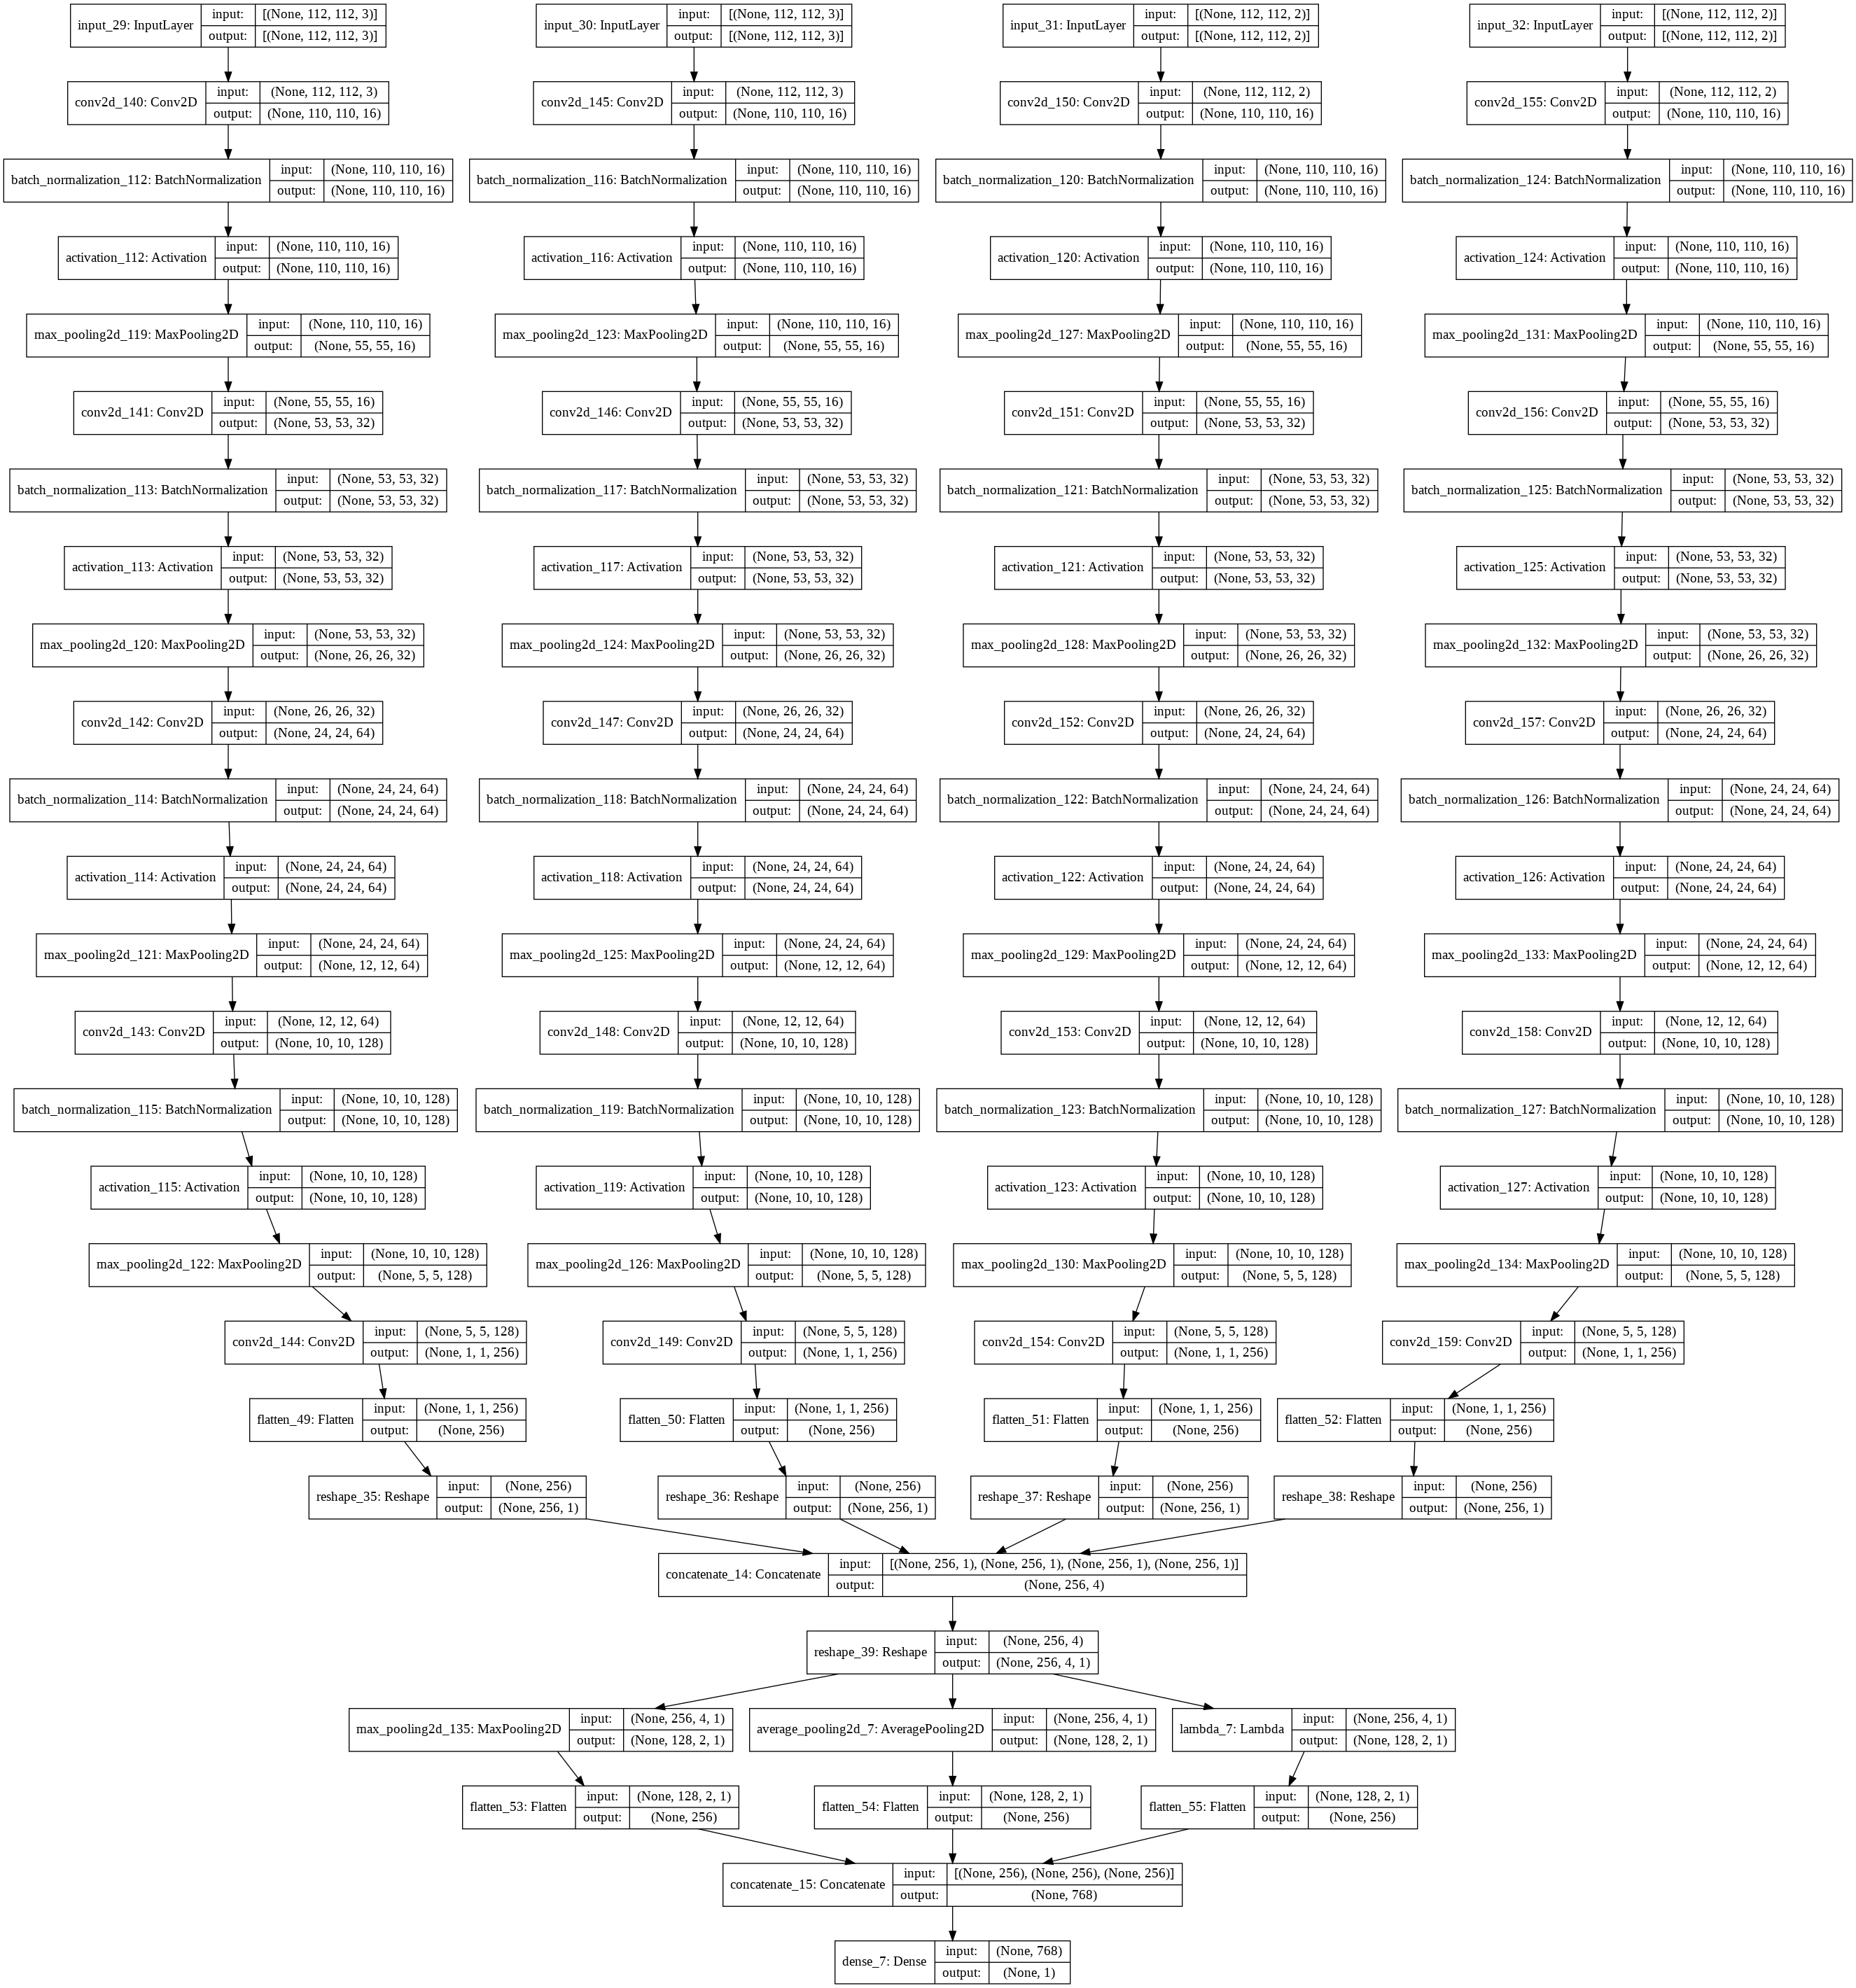

In [ ]:
tf.keras.utils.plot_model(
    model,
    to_file="model.png",
    show_shapes=True,
    show_dtype=False,
    show_layer_names=True,
    rankdir="TB",
    expand_nested=False,
    dpi=96,
)

In [ ]:
INIT_LR = 1e-3
BS = 8
EPOCHS = 4

In [ ]:
# opt = Adam(lr=INIT_LR)
opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
model.compile(loss="binary_crossentropy", optimizer=opt,
	metrics=["accuracy"])

In [ ]:
H = model.fit([X_train_C[:,0,...], X_train_C[:,1,...], X_train[:,0,...], X_train[:,1,...]], y_train, batch_size=BS,
	validation_split=0.2,
	epochs=EPOCHS)

Epoch 1/4
1796/1796 [==============================] - 36s 18ms/step - loss: 1.0532 - accuracy: 0.8254 - val_loss: 0.3829 - val_accuracy: 0.8769
Epoch 2/4
1796/1796 [==============================] - 32s 18ms/step - loss: 0.0764 - accuracy: 0.9727 - val_loss: 0.0753 - val_accuracy: 0.9722
Epoch 3/4
1796/1796 [==============================] - 32s 18ms/step - loss: 0.0422 - accuracy: 0.9845 - val_loss: 0.0862 - val_accuracy: 0.9697
Epoch 4/4
1796/1796 [==============================] - 32s 18ms/step - loss: 0.0228 - accuracy: 0.9909 - val_loss: 0.0296 - val_accuracy: 0.9880


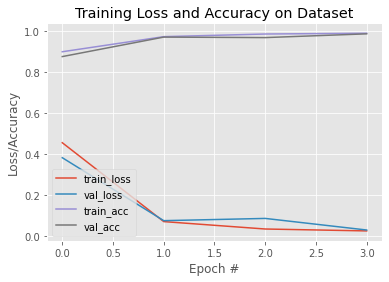

In [ ]:
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, EPOCHS), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, EPOCHS), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, EPOCHS), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, EPOCHS), H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy on Dataset")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")

In [ ]:
model.evaluate([X_test_C[:,0,...], X_test_C[:,1,...], X_test[:,0,...], X_test[:,1,...]], y_test, batch_size=BS)

562/562 [==============================] - 6s 10ms/step - loss: 0.0304 - accuracy: 0.9902


[0.030366485938429832, 0.9902026057243347]

In [ ]:
# big_model_04_10.h5 our
model.save('of_rp_prnet.h5')

In [ ]:
!cp 'of_rp_prnet.h5' '/content/drive/MyDrive/RoseYoutu/'

In [ ]:
del X_test
del y_test

# TEsting with data_video

In [ ]:
!cp '/content/drive/MyDrive/RoseYoutu/data_video_nuaa_prnet/data_video.zip' './'

In [ ]:
!cp '/content/drive/MyDrive/RoseYoutu/data_video_nuaa_prnet/client.txt' './'

In [ ]:
!cp '/content/drive/MyDrive/RoseYoutu/data_video_nuaa_prnet/imposter.txt' './'

In [ ]:
!unzip data_video.zip

Streaming output truncated to the last 5000 lines.
  inflating: data_video/client/0013_01_07_03/0013_01_07_03_188.jpg  
  inflating: data_video/client/0013_01_07_03/0013_01_07_03_218.jpg  
  inflating: data_video/client/0013_01_07_03/0013_01_07_03_62.jpg  
  inflating: data_video/client/0013_01_07_03/0013_01_07_03_171.jpg  
  inflating: data_video/client/0013_01_07_03/0013_01_07_03_112.jpg  
  inflating: data_video/client/0013_01_07_03/0013_01_07_03_7.jpg  
  inflating: data_video/client/0013_01_07_03/0013_01_07_03_486.jpg  
  inflating: data_video/client/0013_01_07_03/0013_01_07_03_344.jpg  
  inflating: data_video/client/0013_01_07_03/0013_01_07_03_455.jpg  
  inflating: data_video/client/0013_01_07_03/0013_01_07_03_260.jpg  
  inflating: data_video/client/0013_01_07_03/0013_01_07_03_458.jpg  
  inflating: data_video/client/0013_01_07_03/0013_01_07_03_268.jpg  
  inflating: data_video/client/0013_01_07_03/0013_01_07_03_118.jpg  
  inflating: data_video/client/0013_01_07_03/0013_01_07

In [ ]:
detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor('shape_predictor_68_face_landmarks.dat')
client_dataset = {}
for name in os.listdir('/content/data_video/client'):
    client_dataset[name] = []

In [ ]:
# imagePaths = list(paths.list_images('/content/data_our/client'))
imagePaths = list(map(lambda x: x.rstrip(),open('client.txt').readlines()))
num_of_images = len(imagePaths)
for(i, data) in enumerate(imagePaths):
    print(data)
    print(f'Processing image {i}/{num_of_images}')
    label = data.split('/')[-2]
    img = dlib.load_rgb_image(data)
    dets = detector(img)
    for d in dets:
        shape = predictor(img, d)
        temp = dlib.get_face_chip(img, shape, size=INPUT_SIZE)
        # temp = temp.astype('float32')
        # standardize pixel values across channels (global)
        # mean, std = temp.mean(), temp.std()
        # temp = (temp - mean) / std
        # client_dataset[label].append(temp.reshape(1, INPUT_SIZE, INPUT_SIZE, 3))
        client_dataset[label].append(temp)

Streaming output truncated to the last 5000 lines.
/content/data_video/client/0007_01_05_03/0007_01_05_03_292.jpg
Processing image 2604/5104
/content/data_video/client/0007_01_05_03/0007_01_05_03_293.jpg
Processing image 2605/5104
/content/data_video/client/0007_01_05_03/0007_01_05_03_294.jpg
Processing image 2606/5104
/content/data_video/client/0007_01_05_03/0007_01_05_03_295.jpg
Processing image 2607/5104
/content/data_video/client/0007_01_05_03/0007_01_05_03_296.jpg
Processing image 2608/5104
/content/data_video/client/0007_01_05_03/0007_01_05_03_297.jpg
Processing image 2609/5104
/content/data_video/client/0007_01_05_03/0007_01_05_03_298.jpg
Processing image 2610/5104
/content/data_video/client/0007_01_05_03/0007_01_05_03_299.jpg
Processing image 2611/5104
/content/data_video/client/0007_01_05_03/0007_01_05_03_300.jpg
Processing image 2612/5104
/content/data_video/client/0007_01_05_03/0007_01_05_03_301.jpg
Processing image 2613/5104
/content/data_video/client/0007_01_05_03/0007_01_

In [ ]:
import tqdm

In [ ]:
C1_ = []
C1000_ = []
X_10 = []
X_20 = []
for (key, values) in tqdm.tqdm(client_dataset.items()):
  for i in range(len(values)):
    if len(values) < 20:
      print('Not valid')
      break
    if i + 19 > len(values) - 1 :
      break
    else:
      old = values[i][...,::-1]
      new_10 = values[i+9][...,::-1]
      new_20 = values[i+19][...,::-1]
      old_flip = cv2.flip(old, 1)
      new_10_flip = cv2.flip(new_10, 1)
      new_20_flip = cv2.flip(new_20, 1)
      old_gray = cv2.cvtColor(old, cv2.COLOR_BGR2GRAY)
      new_10_gray = cv2.cvtColor(new_10, cv2.COLOR_BGR2GRAY)
      new_20_gray = cv2.cvtColor(new_20, cv2.COLOR_BGR2GRAY)
      old_gray_flip = cv2.cvtColor(old_flip, cv2.COLOR_BGR2GRAY)
      new_10_gray_flip = cv2.cvtColor(new_10_flip, cv2.COLOR_BGR2GRAY)
      new_20_gray_flip = cv2.cvtColor(new_20_flip, cv2.COLOR_BGR2GRAY)
      flow = cv2.calcOpticalFlowFarneback(old_gray, new_10_gray, None, 0.5, 3, 29, 3, 5, 1.2, 0)
      X_10.append(flow)
      flow = cv2.calcOpticalFlowFarneback(old_gray, new_20_gray, None, 0.5, 3, 29, 3, 5, 1.2, 0)
      X_20.append(flow)
      flow = cv2.calcOpticalFlowFarneback(old_gray_flip, new_10_gray_flip, None, 0.5, 3, 29, 3, 5, 1.2, 0)
      X_10.append(flow)
      flow = cv2.calcOpticalFlowFarneback(old_gray_flip, new_20_gray_flip, None, 0.5, 3, 29, 3, 5, 1.2, 0)
      X_20.append(flow)
      sequence_flip = []
      for _ in values[i:i+20]:
        sequence_flip.append(cv2.flip(_, 1))
      rankpooling_1 = C1.run(values[i:i+20])
      C1_.append(rankpooling_1)
      rankpooling_1000 = C1000.run(values[i:i+20])
      C1000_.append(rankpooling_1000)
      rankpooling_1 = C1.run(sequence_flip)
      C1_.append(rankpooling_1)
      rankpooling_1000 = C1000.run(sequence_flip)
      C1000_.append(rankpooling_1000)


100%|██████████| 25/25 [15:31<00:00, 37.27s/it]


In [ ]:
del client_dataset

In [ ]:
C1_ = np.array(C1_)
C1000_ = np.array(C1000_)
X_10 = np.array(X_10)
X_20 = np.array(X_20)
C1_.shape, C1000_.shape, X_10.shape, X_20.shape

((9222, 112, 112, 3),
 (9222, 112, 112, 3),
 (9222, 112, 112, 2),
 (9222, 112, 112, 2))

In [ ]:
detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor('shape_predictor_68_face_landmarks.dat')
imposter_dataset = {}
for name in os.listdir('/content/data_video/imposter'):
    imposter_dataset[name] = []

In [ ]:
# imagePaths = list(paths.list_images('/content/data_rose/imposter'))
imagePaths = list(map(lambda x: x.rstrip(),open('imposter.txt').readlines()))
num_of_images = len(imagePaths)
for(i, data) in enumerate(imagePaths):
    print(data)
    print(f'Processing image {i}/{num_of_images}')
    label = data.split('/')[-2]
    img = dlib.load_rgb_image(data)
    dets = detector(img)
    for d in dets:
        shape = predictor(img, d)
        temp = dlib.get_face_chip(img, shape, size=INPUT_SIZE)
        # temp = temp.astype('float32')
        # standardize pixel values across channels (global)
        # mean, std = temp.mean(), temp.std()
        # temp = (temp - mean) / std
        # imposter_dataset[label].append(temp.reshape(1, INPUT_SIZE, INPUT_SIZE, 3))
        imposter_dataset[label].append(temp)

Streaming output truncated to the last 5000 lines.
/content/data_video/imposter/0009_01_03_02/0009_01_03_02_224.jpg
Processing image 5006/7506
/content/data_video/imposter/0009_01_03_02/0009_01_03_02_242.jpg
Processing image 5007/7506
/content/data_video/imposter/0009_01_03_02/0009_01_03_02_260.jpg
Processing image 5008/7506
/content/data_video/imposter/0009_01_03_02/0009_01_03_02_279.jpg
Processing image 5009/7506
/content/data_video/imposter/0009_01_03_02/0009_01_03_02_297.jpg
Processing image 5010/7506
/content/data_video/imposter/0009_01_03_02/0009_01_03_02_314.jpg
Processing image 5011/7506
/content/data_video/imposter/0009_01_03_02/0009_01_03_02_332.jpg
Processing image 5012/7506
/content/data_video/imposter/0009_01_03_02/0009_01_03_02_350.jpg
Processing image 5013/7506
/content/data_video/imposter/0009_01_03_02/0009_01_03_02_369.jpg
Processing image 5014/7506
/content/data_video/imposter/0009_01_03_02/0009_01_03_02_387.jpg
Processing image 5015/7506
/content/data_video/imposter/

In [ ]:
C1_imposter = []
C1000_imposter = []
X_10_imposter = []
X_20_imposter = []
for (key, values) in tqdm.tqdm(imposter_dataset.items()):
  for i in range(len(values)):
    if len(values) < 20:
      print('Not valid')
      break
    if i + 19 > len(values) - 1 :
      break
    else:
      old = values[i][...,::-1]
      new_10 = values[i+9][...,::-1]
      new_20 = values[i+19][...,::-1]
      old_flip = cv2.flip(old, 1)
      new_10_flip = cv2.flip(new_10, 1)
      new_20_flip = cv2.flip(new_20, 1)
      old_gray = cv2.cvtColor(old, cv2.COLOR_BGR2GRAY)
      new_10_gray = cv2.cvtColor(new_10, cv2.COLOR_BGR2GRAY)
      new_20_gray = cv2.cvtColor(new_20, cv2.COLOR_BGR2GRAY)
      old_gray_flip = cv2.cvtColor(old_flip, cv2.COLOR_BGR2GRAY)
      new_10_gray_flip = cv2.cvtColor(new_10_flip, cv2.COLOR_BGR2GRAY)
      new_20_gray_flip = cv2.cvtColor(new_20_flip, cv2.COLOR_BGR2GRAY)
      flow = cv2.calcOpticalFlowFarneback(old_gray, new_10_gray, None, 0.5, 3, 29, 3, 5, 1.2, 0)
      X_10_imposter.append(flow)
      flow = cv2.calcOpticalFlowFarneback(old_gray, new_20_gray, None, 0.5, 3, 29, 3, 5, 1.2, 0)
      X_20_imposter.append(flow)
      flow = cv2.calcOpticalFlowFarneback(old_gray_flip, new_10_gray_flip, None, 0.5, 3, 29, 3, 5, 1.2, 0)
      X_10_imposter.append(flow)
      flow = cv2.calcOpticalFlowFarneback(old_gray_flip, new_20_gray_flip, None, 0.5, 3, 29, 3, 5, 1.2, 0)
      X_20_imposter.append(flow)
      sequence_flip = []
      for _ in values[i:i+20]:
        sequence_flip.append(cv2.flip(_, 1))
      rankpooling_1 = C1.run(values[i:i+20])
      C1_imposter.append(rankpooling_1)
      rankpooling_1000 = C1000.run(values[i:i+20])
      C1000_imposter.append(rankpooling_1000)
      rankpooling_1 = C1.run(sequence_flip)
      C1_imposter.append(rankpooling_1)
      rankpooling_1000 = C1000.run(sequence_flip)
      C1000_imposter.append(rankpooling_1000)


100%|██████████| 118/118 [30:49<00:00, 15.68s/it]


In [ ]:
del imposter_dataset

In [ ]:
C1_imposter = np.array(C1_imposter)
C1000_imposter = np.array(C1000_imposter)
X_10_imposter = np.array(X_10_imposter)
X_20_imposter = np.array(X_20_imposter)
C1_imposter.shape, C1000_imposter.shape, X_10_imposter.shape, X_20_imposter.shape

((10304, 112, 112, 3),
 (10304, 112, 112, 3),
 (10304, 112, 112, 2),
 (10304, 112, 112, 2))

In [ ]:
with open('X_10_29_5.pickle', 'rb') as handle:
  X_10 = pickle.load(handle)
with open('X_20_29_5.pickle', 'rb') as handle:
  X_20 = pickle.load(handle)
with open('C1__29_5.pickle', 'rb') as handle:
  C1_ = pickle.load(handle)
with open('C1000__29_5.pickle', 'rb') as handle:
  C1000_ = pickle.load(handle)

In [ ]:
with open('C1__29_5.pickle', 'rb') as handle:
  C1_ = pickle.load(handle)
with open('C1_imposter_29_5.pickle', 'rb') as handle:
  C1_imposter = pickle.load(handle)

In [ ]:
y = np.array([0]*C1_.shape[0] + [1]*C1_imposter.shape[0])

In [ ]:
len(y)

19526

In [ ]:
C1_total = np.vstack((C1_, C1_imposter))
del C1_
del C1_imposter

C1000_total = np.vstack((C1000_, C1000_imposter))
del C1000_
del C1000_imposter

X_10_total = np.vstack((X_10, X_10_imposter))
del X_10
del X_10_imposter

X_20_total = np.vstack((X_20, X_20_imposter))
del X_20
del X_20_imposter

In [ ]:
with open('C1_total_nuaa_2.pickle', 'wb') as handle:
  pickle.dump(C1_total, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
with open('C1000_total_nuaa_2.pickle', 'wb') as handle:
  pickle.dump(C1000_total, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
with open('X_10_total_nuaa_2.pickle', 'wb') as handle:
  pickle.dump(X_10_total, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
with open('X_20_total_nuaa_2.pickle', 'wb') as handle:
  pickle.dump(X_20_total, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
with open('y_nuaa_total.pickle', 'wb') as handle:
  pickle.dump(y, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
with open('C1_total_nuaa_2.pickle', 'rb') as handle:
  C1_total = pickle.load(handle)

In [ ]:
with open('C1000_total_nuaa_2.pickle', 'rb') as handle:
  C1000_total = pickle.load(handle)

In [ ]:
with open('X_10_total_nuaa_2.pickle', 'rb') as handle:
  X_10_total = pickle.load(handle)

In [ ]:
with open('X_20_total_nuaa_2.pickle', 'rb') as handle:
  X_20_total = pickle.load(handle)

In [ ]:
with open('y_nuaa_total.pickle', 'rb') as handle:
  y = pickle.load(handle)

In [ ]:
!cp '/content/drive/MyDrive/RoseYoutu/of_rp_prnet.h5' './'

In [ ]:
#'big_model_04_10.h5' our
model = tf.keras.models.load_model('of_rp_prnet.h5')

In [ ]:
model.evaluate([C1_total, C1000_total, X_10_total, X_20_total], y, batch_size=8)

2441/2441 [==============================] - 31s 7ms/step - loss: 1.8133 - accuracy: 0.6972


[1.8132843971252441, 0.6972241997718811]

In [ ]:
y_pred = []
for _ in range(C1_total.shape[0]):
  pred = model.predict([C1_total[_].reshape(1, INPUT_SIZE, INPUT_SIZE, 3), C1000_total[_].reshape(1, INPUT_SIZE, INPUT_SIZE, 3), X_10_total[_].reshape(1, INPUT_SIZE, INPUT_SIZE, 2), X_20_total[_].reshape(1, INPUT_SIZE, INPUT_SIZE, 2)]).flatten()[0]
  if pred > 0.5:
    y_pred.append(1)
  else:
    y_pred.append(0)

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y, y_pred, digits=4))

              precision    recall  f1-score   support

           0     0.6159    0.9538    0.7485      9222
           1     0.9188    0.4676    0.6198     10304

    accuracy                         0.6972     19526
   macro avg     0.7673    0.7107    0.6841     19526
weighted avg     0.7757    0.6972    0.6805     19526



In [ ]:
from sklearn.metrics import confusion_matrix

In [ ]:
CM = confusion_matrix(y, y_pred)

In [ ]:
TN = CM[0][0]
FN = CM[1][0]
TP = CM[1][1]
FP = CM[0][1]

In [ ]:
APCER = FP / (TN + FP)
BPCER = FN / (TP + FN)

In [ ]:
APCER, BPCER

(0.04619388418998048, 0.5324145962732919)

In [ ]:
(APCER + BPCER) / 2

0.2893042402316362

In [ ]:
!cp  '/content/drive/MyDrive/RoseYoutu/data_video_nuaa_prnet/X_10_29_5.pickle' './'

In [ ]:
!cp  '/content/drive/MyDrive/RoseYoutu/data_video_nuaa_prnet/X_20_29_5.pickle' './'

In [ ]:
!cp  '/content/drive/MyDrive/RoseYoutu/data_video_nuaa_prnet/C1__29_5.pickle' './'

In [ ]:
!cp  '/content/drive/MyDrive/RoseYoutu/data_video_nuaa_prnet/C1000__29_5.pickle' './'

In [ ]:
!cp  '/content/drive/MyDrive/RoseYoutu/data_video_nuaa_prnet/C1_imposter_29_5.pickle' './'

In [ ]:
!cp '/content/drive/MyDrive/RoseYoutu/data_video_nuaa_prnet/C1000_total_nuaa_2.pickle'  './'

In [ ]:
!cp '/content/drive/MyDrive/RoseYoutu/data_video_nuaa_prnet/C1_total_nuaa_2.pickle' './'

In [ ]:
!cp '/content/drive/MyDrive/RoseYoutu/data_video_nuaa_prnet/X_10_total_nuaa_2.pickle' './'

In [ ]:
!cp '/content/drive/MyDrive/RoseYoutu/data_video_nuaa_prnet/X_20_total_nuaa_2.pickle' './'

In [ ]:
!cp '/content/drive/MyDrive/RoseYoutu/data_video_nuaa_prnet/y_nuaa_total.pickle' './'

In [ ]:
đạo hàm của motion field
check 2 ảnh thật và giả toàn frame

lớp sv, dung gio hay ko dung h, m
mat nhieu thoi gian ?
can do cai flow lai
DASHBOARD
setup trc
